# Web Scraping IMDb Top 250 Movies

#### Rizky Nurhidayat | 04/07/2024

## Introduction
Web scraping is a technique used to extract information from websites automatically using computer programs. This project aims to collect data from IMDb's Top 250 movies list, which is determined based on ratings from regular IMDb voters. IMDb is one of the largest movie databases globally, providing detailed information about movies, actors, crew, and user reviews.

## Objectives
1. Scrape data from the IMDb Top 250 movies page.
2. Clean and process the collected data.
3. Analyze the data to gain insights into top-rated movies.
4. Present the analysis results through easy-to-understand visualizations.

## Methods
1. Web Scraping:
   - Used *'requests'* and *'BeautifulSoup'* libraries to fetch and parse the main IMDb Top 250 page.
   - Employed *'selenium'* to simulate scrolling on the page to ensure all data loads before scraping.
   - Extracted links to individual movie pages from the main page for further data scraping.
2. Data Processing: Utilized *'pandas'* for data cleaning and organization.
3. Visualization: Applied *'matplotlib'* and *'seaborn'* for creating various data visualizations.

In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.firefox.options import Options
from bs4 import BeautifulSoup
import requests
import time
import re
import pandas as pd
from tqdm.notebook import tqdm

In [2]:
base_url = 'https://www.imdb.com/'
url = 'https://www.imdb.com/chart/top/'

In [3]:
options = Options()
options.add_argument("--headless")
driver = webdriver.Firefox(options=options)
driver.get(url)

last_height = driver.execute_script("return document.body.scrollHeight")
while True:
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(0.5)
    new_height = driver.execute_script("return document.body.scrollHeight")
    if new_height == last_height:
        break
    last_height = new_height

soup = BeautifulSoup(driver.page_source, 'lxml')

In [4]:
top_movie = soup.find_all('li', class_ = 'ipc-metadata-list-summary-item sc-10233bc-0 iherUv cli-parent')

movie_links = []
for item in top_movie:
    link = base_url + item.find('a').get('href')
    movie_links.append(link)

In [ ]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/126.0.0.0 Safari/537.36 Edg/126.0.0.0'
}

movies_list = []
rank = 0
for link in tqdm((movie_links), desc = 'In progress of retrieving data:'):
    r = requests.get(link, headers = headers)
    soup = BeautifulSoup(r.content, 'lxml')

    rank += 1
    title = soup.find('title').text[:-14]
    items = [i.text for i in soup.find('ul', class_ = 'ipc-inline-list ipc-inline-list--show-dividers sc-d8941411-2 cdJsTz baseAlt')]; year = items[0] if len(items) > 0 else None; duration = items[-1] if len(items) > 1 else None; rating = items[1] if len(items) > 2 else None
    imdb_rating = soup.find('span', class_ = 'sc-eb51e184-1 cxhhrI').text
    vote_count = soup.find('div', class_ = 'sc-eb51e184-3 gUihYJ').text
    poster = base_url + soup.find('a', class_ = 'ipc-lockup-overlay ipc-focusable').get('href')
    genres_list = soup.find_all('span', class_ = 'ipc-chip__text')[:-1]
    genres = ', '.join([genre.text for genre in genres_list])
    plot = soup.find('span', class_ = 'sc-2d37a7c7-0 caYjFF').text
    directors_list = soup.find('span', class_ = 'ipc-metadata-list-item__label ipc-metadata-list-item__label--btn', string = re.compile('Director')).find_next('div').find_all('a')
    directors = ', '.join([director.text for director in directors_list])
    stars_list = soup.find('a', class_ = 'ipc-metadata-list-item__label ipc-metadata-list-item__label--link', string = 'Stars').find_next('div').find_all('a')
    stars = ', '.join([star.text for star in stars_list])
    
    movies_list.append({
        'IMDb Ranking': rank,
        'Title': title,
        'Year Release': year,
        'Age Rating': rating,
        'Duration': duration,
        'IMDb Rating': imdb_rating,
        'Vote Count': vote_count,
        'Genre': genres,
        'Plot': plot,
        'Directors': directors,
        'Stars': stars,
        'Poster': poster,
        'URL': link
    })

## Results

In [6]:
df = pd.DataFrame(movies_list)
df.to_csv('IMDb Top 250 Movies.csv', index = False)

### Rating Distribution
A bar chart displaying the distribution of IMDb ratings for the Top 250 movies.
As can be seen below, the smaller the rating, the greater the number of movies. Conversely, the higher the rating, the fewer movies there will be.

This shows that the distribution of movie ratings on IMDb follows a normal distribution pattern or approaches a normal distribution. Although low rating data is not shown here, in this pattern, most movies would have ratings around the middle or average, with fewer movies having very high or very low ratings. In the context of IMDb, movies with very high ratings (such as 9 or 10) are usually very special movies, both in terms of story, acting, directing, and their impact on audiences and popular culture.

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

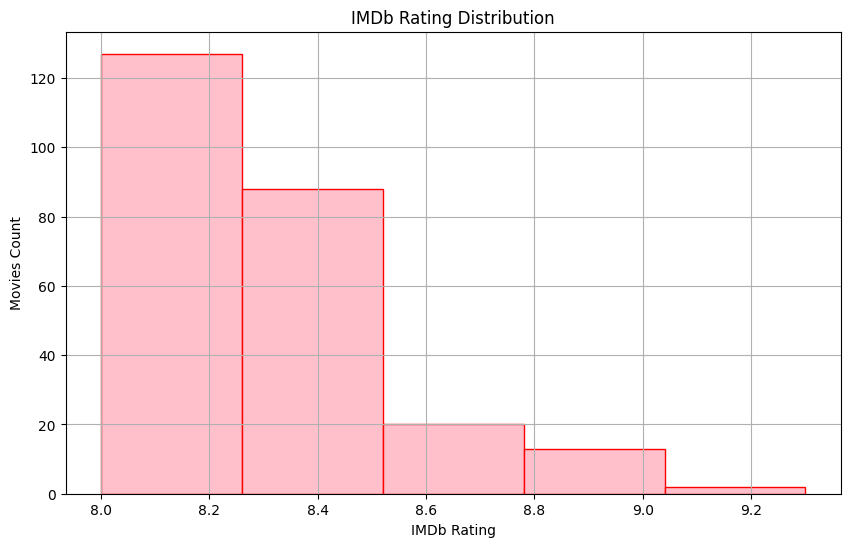

In [8]:
df['IMDb Rating']= df['IMDb Rating'].astype(float)
plt.figure(figsize=(10, 6))

plt.hist(df['IMDb Rating'], bins=5, color='pink', edgecolor='red')
plt.title('IMDb Rating Distribution')
plt.xlabel('IMDb Rating')
plt.ylabel('Movies Count')
plt.grid(True)
plt.show()

### Top Movies
A scatter chart showing Top 250 movies based on IMDb Rating over the years.

Only a handful of movies have earned a rating above or equal to 9. Among the ones that consistently stand out are Frank Darabont's "The Shawshank Redemption" (1994), followed by Francis Ford Coppola's "The Godfather" (1972) and "The Dark Knight" (2008) by Christopher Nolan. In fourth place was "The Godfather: Part II" (1974), also by Francis Ford Coppola. No less important, "12 Angry Men" (1957) directed by Sidney Lumet ranks fifth.

Although most of these great movies were released before the 21st century, 21st century movies also retain their appeal for audiences and critics. Most of the best movies fall between the late 20th and early 21st centuries on this list.


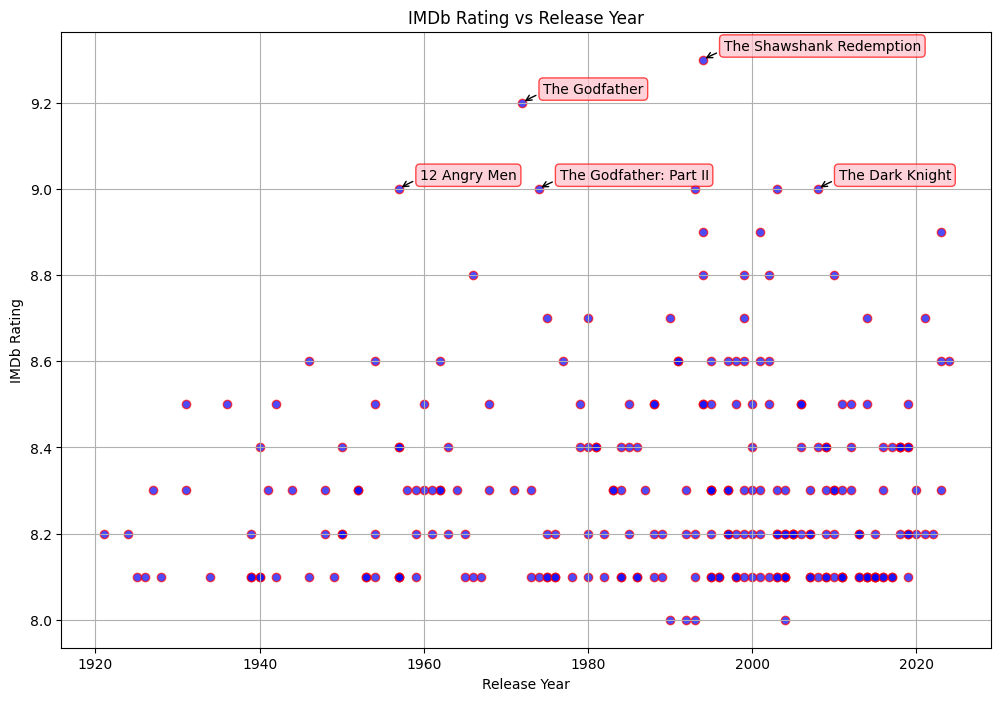

In [9]:
df['Year Release'] = df['Year Release'].astype(int)
plt.figure(figsize=(12, 8))
plt.scatter(df['Year Release'], df['IMDb Rating'], color='blue', edgecolors='red', alpha=0.7)

top_5_movies = df.nlargest(5, 'IMDb Rating')
for i, row in top_5_movies.iterrows():
    plt.annotate(row['Title'], 
                 (row['Year Release'], row['IMDb Rating']), 
                 textcoords="offset points", 
                 xytext=(15,7), 
                 ha='left', 
                 fontsize=10, 
                 bbox=dict(boxstyle="round,pad=0.3", edgecolor="red", facecolor="pink", alpha=0.7),
                 arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.2", color='black'))


plt.title('IMDb Rating vs Release Year')
plt.xlabel('Release Year')
plt.ylabel('IMDb Rating')
plt.grid(True)
plt.show()

### Top 10 Genres
A horizontal bar chart indicating the most common genres among the Top 250 movies.

Drama dominates the list, followed by Action and Crime, reflecting viewers' preference for deep and intense storytelling.

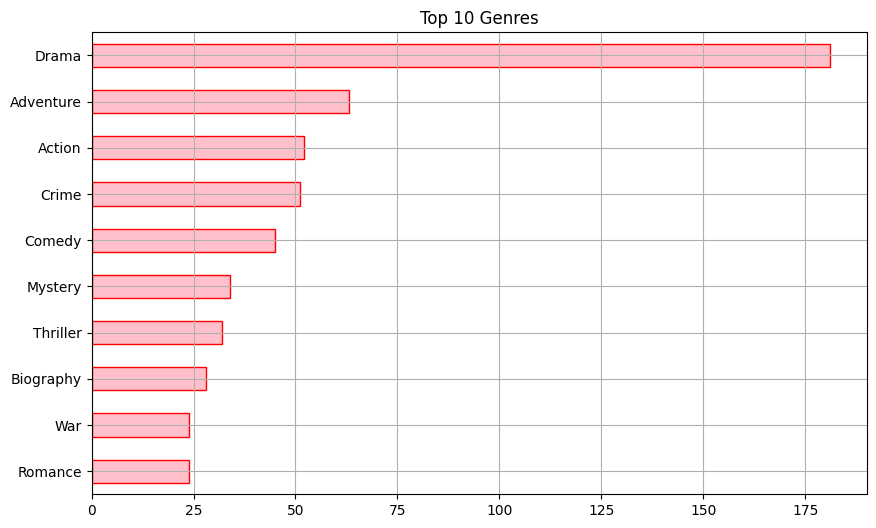

In [19]:
genres = df['Genre'].str.split(', ').explode()
genre_counts = genres.value_counts().head(10).sort_values()

plt.figure(figsize=(10, 6))
genre_counts.plot(kind='barh', color='pink', edgecolor='red')
plt.title('Top 10 Genres')
plt.ylabel('')
plt.grid(True)
plt.show()

### Top 10 Directors
A horizontal bar chart showing the directors who frequently appear in the list.

Names like Christopher Nolan, Martin Scorsese, Stanley Kubrick, and Steven Spielberg appear multiple times, showcasing their significant influence in the movie industry.

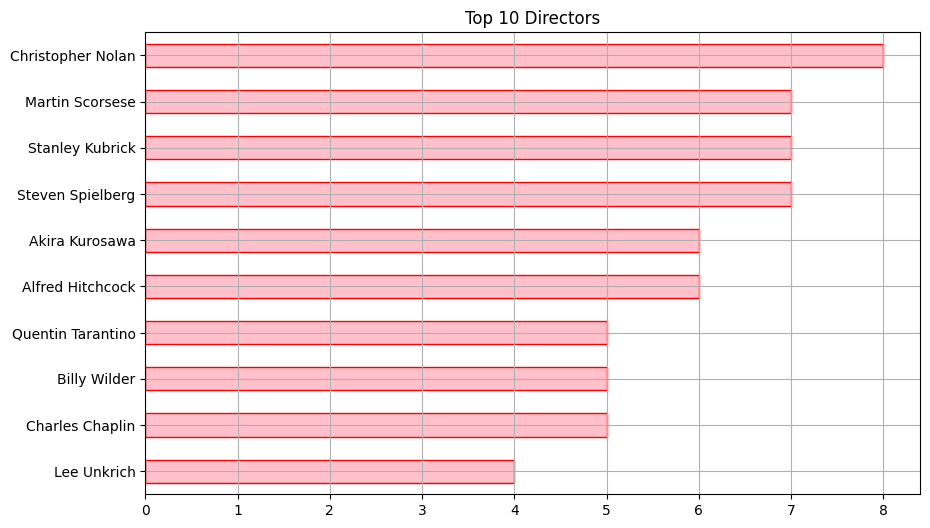

In [20]:
directors = df['Directors'].str.split(', ').explode()
director_counts = directors.value_counts().head(10).sort_values()

plt.figure(figsize=(10, 6))
director_counts.plot(kind='barh', color='pink', edgecolor='red')
plt.title('Top 10 Directors')
plt.ylabel('')
plt.grid(True)
plt.show()

### Top 10 Actors
A horizontal bar chart highlighting the actors who frequently appear in the list.

Actors such as Robert De Niro, Leonardo DiCaprio, Tom Hanks, and Harrison Ford frequently appear, demonstrating their exceptional acting skills.

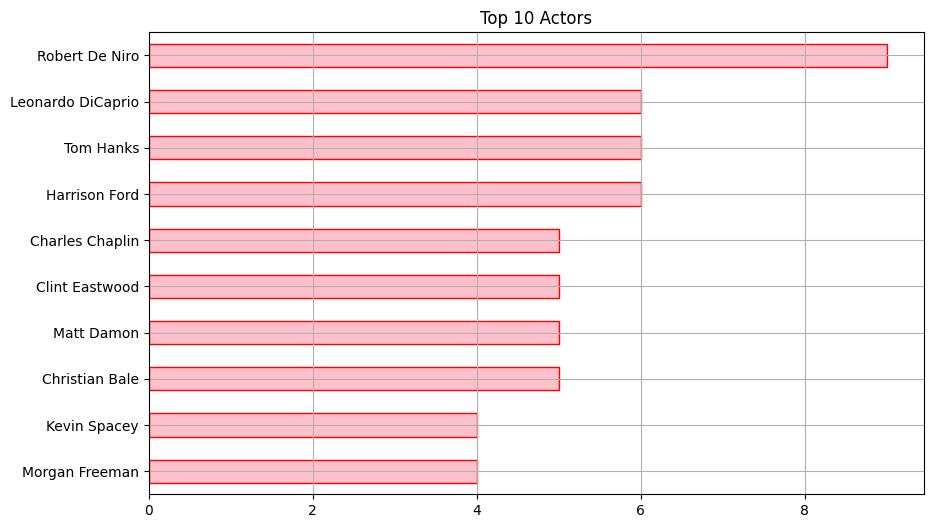

In [21]:
stars = df['Stars'].str.split(', ').explode()
star_counts = stars.value_counts().head(10).sort_values()

plt.figure(figsize=(10, 6))
star_counts.plot(kind='barh', color='pink', edgecolor='red')
plt.title('Top 10 Actors')
plt.ylabel('')
plt.grid(True)
plt.show()

## Conclusion
This project successfully scraped and analyzed data from IMDb's Top 250 movies. The analysis provides valuable insights into movie trends, genre preferences, and influential actors and directors. Web scraping and data analysis have proven to be powerful tools for exploring and understanding large amounts of data from the internet.